# Background

This notebook accompanies the medium article **Making Your Loss Function Count**.

The code within highlights how to use a custom loss function in Tensorflow in a hypothetical scenario, in which you  work for a leisure centre where customers can sign up for different price tiers each month, and your job is to predict whether they will trade up, trade down, or remain at the same price tier in the next month.

### Gym price plans

![title](Images/Gym_Price_Plans.png)

# Import libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
from sklearn import metrics, model_selection, preprocessing
import tensorflow as tf
from tensorflow.keras import losses
from tensorflow.keras import utils as keras_utils
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model, Sequential
from typing import Tuple

# Create dummy data

In [2]:
number_of_observations_per_class = 10000

#### Customers who trade down (assumed to be on their current plan for less time and not using the gym as often)

In [3]:
dict_trade_down = {
    'Shift_In_Visits_Vs_Last_Month': np.random.uniform(low=0.7, high=1.1, size=number_of_observations_per_class),
    'Months_On_Price_Tier': np.random.randint(low=0, high=3, size=number_of_observations_per_class),
    'Class': np.repeat(a='Down', repeats=number_of_observations_per_class)
}

df_trade_down = pd.DataFrame(data=dict_trade_down)

#### Customers who remain stable (assumed to be on their current plan for a longer period of time, and using the gym a consistent amount)

In [4]:
dict_stable = {
    'Shift_In_Visits_Vs_Last_Month': np.random.uniform(low=0.7, high=1.15, size=number_of_observations_per_class),
    'Months_On_Price_Tier': np.random.randint(low=0, high=5, size=number_of_observations_per_class),
    'Class': np.repeat(a='Stable', repeats=number_of_observations_per_class)
}

df_stable = pd.DataFrame(data=dict_stable)

#### Customers who trade up (assumed to be on their current plan for less time and are using the gym more often)



In [5]:
dict_trade_up = {
    'Shift_In_Visits_Vs_Last_Month': np.random.uniform(low=0.7, high=1.2, size=number_of_observations_per_class),
    'Months_On_Price_Tier': np.random.randint(low=0, high=3, size=number_of_observations_per_class),
    'Class': np.repeat(a='Up', repeats=number_of_observations_per_class)
}

df_trade_up = pd.DataFrame(data=dict_trade_up)

# Concatenate into one single dataframe and randomly shuffle

In [6]:
df_all = pd.concat([df_trade_down, df_stable, df_trade_up]).sample(frac=1)

df_all.head()

,Shift_In_Visits_Vs_Last_Month,Months_On_Price_Tier,Class
4152,0.808516,2,Up
2359,0.967673,1,Stable
8128,0.836413,0,Down
5081,1.013918,1,Up
9423,1.141225,3,Stable


# Represent class labels as integers

In [7]:
label_encoder = preprocessing.LabelEncoder()
label_encoder = label_encoder.fit(df_all['Class'])

print('Label mapping: ')
label_mapping = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))
print(label_mapping)

# Transform the original datasets
df_all['Class_Integer'] = label_encoder.transform(df_all['Class'])

df_all[['Class', 'Class_Integer']].head(10)

Label mapping: 
{'Down': 0, 'Stable': 1, 'Up': 2}


,Class,Class_Integer
4152,Up,2
2359,Stable,1
8128,Down,0
5081,Up,2
9423,Stable,1
4169,Stable,1
8326,Up,2
7773,Up,2
4007,Stable,1
4985,Stable,1


# Split into training and validation dataset
No test dataset is taken in this demo for simplicity

In [8]:
features = df_all.loc[:, ['Shift_In_Visits_Vs_Last_Month', 'Months_On_Price_Tier']]
labels = df_all.loc[:, 'Class_Integer']

X_train, X_validation, y_train, y_validation = model_selection.train_test_split(features, labels, test_size=0.2)

y_train_encoded = keras_utils.to_categorical(y_train, num_classes=3)
y_validation_encoded = keras_utils.to_categorical(y_validation, num_classes=3)

# Make note of how damaging each prediction vs reality would be for the business

![title](Images/Prediction_Risk.png)

In [9]:
scenario_risk = {}

#### If prediction matches reality... it is good news so assign a standard weight of 1

In [10]:
scenario_risk['prediction_matches_reality'] = 1.0

#### If customer trades down (0) but we predicted stable (1), or if customer stays stable (1) but we predicted up (2)... it is bad news as we made less revenue than expected

In [11]:
scenario_risk['less_spend_than_expected'] = 3.0

#### If customer trades down (0) but we predicted up (2)... it is REALLY bad news as we made a lot less revenue than expected

In [12]:
scenario_risk['much_less_spend_than_expected'] = 9.0

#### If customer is stable (1) but we predicted down (0), or if customer trades up (2) but we predicted stable (1)... it is not such bad news as we made more revenue than expected

In [13]:
scenario_risk['more_spend_than_expected'] = 1.25

#### If customer trades up (2) but we predicted down (0)... it is definitely not such bad news as we made a lot more revenue than expected

In [14]:
scenario_risk['much_more_spend_than_expected'] = 1.05

#### Summarise

In [15]:
print('Scenario risks: \n')
for key, value in scenario_risk.items(): print(f'{key}: {value}')

Scenario risks: 

prediction_matches_reality: 1.0
less_spend_than_expected: 3.0
much_less_spend_than_expected: 9.0
more_spend_than_expected: 1.25
much_more_spend_than_expected: 1.05


# Normalise risks

We will want to apply these weights to help with back-propagation and forcing the model to place more importance under certain scenarios. We want to avoid having weights greater than 1 as it can distort the learning process and apply weight changes which are too aggressive. As such, divide each weight by the maximum weight to have a normalised version between 0 and 1.

In [16]:
scenario_risk_normalised = {}
worst_case_scenario_risk = np.array(list(scenario_risk.values())).max()

for key, value in scenario_risk.items():
    scenario_risk_normalised[key] = value / worst_case_scenario_risk
    
print('New scenario weights: \n')
for key, value in scenario_risk_normalised.items(): print(f'{key}: {value}')

New scenario weights: 

prediction_matches_reality: 0.1111111111111111
less_spend_than_expected: 0.3333333333333333
much_less_spend_than_expected: 1.0
more_spend_than_expected: 0.1388888888888889
much_more_spend_than_expected: 0.11666666666666667


# Define custom loss function

#### Ensure scenario risks outlined above can be used by Tensorflow

In [17]:
def _convert_scenario_risk_to_tensor(scenario: str) -> tf.Tensor:
    """
    Look up how risky the scenario is when comparing the model prediction to reality, and return a weight score
    indicating how much emphasis the model should place on learning from that particular observation.

    Parameters
    ----------
    scenario : str
        Key of dictionary which shows the risk attached to each scenario. Should be one of...
            'prediction_matches_reality'
            'less_spend_than_expected'
            'much_less_spend_than_expected'
            'more_spend_than_expected'
            'much_more_spend_than_expected'

    Returns
    -------
    tf.Tensor
        Weight which signifies how bad the scenario is for the business, and thus how to update the loss which the
        model is trying to improve.
    """

    return tf.cast(x=tf.constant(scenario_risk_normalised[scenario]), dtype=tf.float32)

#### Ensure the predicted class is compared to the actual class, and the appropriate risk/weight is retrieved

In [18]:
def _get_loss_adjustment_for_scenario(actual_vs_predicted_class: Tuple[tf.Tensor, tf.Tensor]) -> tf.Tensor:
    """
    Return a weight according to how damaging the scenario is to the business.

    Parameters
    ----------
    actual_vs_predicted_class : Tuple[tf.Tensor, tf.Tensor]
       The actual class, actual_vs_predicted_class[0], and the predicted class, actual_vs_predicted_class[1], for an
       observation.

    Returns
    -------
    float
        Weight which signifies how bad the scenario is for the business, and thus how to upweight the loss
        which the model should be trying to improve.
    """

    actual_class = actual_vs_predicted_class[0]
    predicted_class = actual_vs_predicted_class[1]

    # Retrieve the appropriate weighting based on how the prediction compares with reality
    # The labels are:
    # 0: Trade Down, 1: Stable, 2: Trade Up
    return tf.case(
        [
            (tf.equal(actual_class, predicted_class),
             lambda: _convert_scenario_risk_to_tensor('prediction_matches_reality')),

            (tf.logical_and(tf.equal(actual_class, 0), tf.equal(predicted_class, 1)),
             lambda: _convert_scenario_risk_to_tensor('less_spend_than_expected')),

            (tf.logical_and(tf.equal(actual_class, 1), tf.equal(predicted_class, 2)),
             lambda: _convert_scenario_risk_to_tensor('less_spend_than_expected')),

            (tf.logical_and(tf.equal(actual_class, 0), tf.equal(predicted_class, 2)),
             lambda: _convert_scenario_risk_to_tensor('much_less_spend_than_expected')),

            (tf.logical_and(tf.equal(actual_class, 1), tf.equal(predicted_class, 0)),
             lambda: _convert_scenario_risk_to_tensor('more_spend_than_expected')),

            (tf.logical_and(tf.equal(actual_class, 2), tf.equal(predicted_class, 1)),
             lambda: _convert_scenario_risk_to_tensor('more_spend_than_expected')),

            (tf.logical_and(tf.equal(actual_class, 2), tf.equal(predicted_class, 0)),
             lambda: _convert_scenario_risk_to_tensor('much_more_spend_than_expected')),
        ]
    )

#### Place within a custom loss function, which has to be defined to receive two inputs; the true class and the predicted class

In [19]:
def custom_cross_entropy(y_actual: tf.Tensor, y_prediction: tf.Tensor) -> tf.Tensor:
    """
    Calculate cross entropy loss, but weighted according to how risky the scenario is.

    Parameters
    ----------
    y_actual : tf.Tensor
        One-hot encoded representation of the true class for each observation.
    y_prediction : tf.Tensor
        The predicted probability that the observation belongs to each class.
        
    Returns
    -------
    tf.Tensor
        Weighted version of cross-entropy loss depending on how the prediction compares to reality.
    """

    standard_cross_entropy = losses.categorical_crossentropy(y_true=y_actual, y_pred=y_prediction)

    # The label is one hot encoded, so identify the true class by which element contains the maximum value (1)
    actual_class = tf.math.argmax(input=y_actual, axis=1)
    actual_class = tf.cast(x=actual_class, dtype=tf.float32)

    # The prediction is a distribution of probabilities per class,
    # so identify the predicted class by which element contains the maximum probability
    predicted_class = tf.math.argmax(input=y_prediction, axis=1)
    predicted_class = tf.cast(x=predicted_class, dtype=tf.float32)

    actual_vs_predicted_class = tf.stack(values=[actual_class, predicted_class], axis=1)

    # Calculate the weighting that should be applied to each observation in the data
    weighting = tf.map_fn(fn=_get_loss_adjustment_for_scenario, elems=actual_vs_predicted_class)

    # Updated the cross entropy loss based on the weighting
    return tf.math.multiply(standard_cross_entropy, weighting)

# Assemble model with/without custom loss function

In [20]:
# Suppress tensorflow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [21]:
num_features = X_train.shape[1]

#### Standard model

In [22]:
loss = 'categorical_crossentropy'

standard_model = Sequential()

standard_model.add(Input(shape=(num_features, )))
standard_model.add(Dense(64, activation='relu'))
standard_model.add(Dense(32, activation='relu'))
standard_model.add(Dense(len(label_encoder.classes_), activation='softmax'))

standard_model.summary()

standard_model.compile(
    optimizer='adam', 
    loss=loss,
    metrics=['categorical_accuracy', 'categorical_crossentropy']
)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                192       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 99        
Total params: 2,371
Trainable params: 2,371
Non-trainable params: 0
_________________________________________________________________


#### Model with custom loss function

In [23]:
loss = custom_cross_entropy

custom_model = Sequential()

custom_model.add(Input(shape=(num_features, )))
custom_model.add(Dense(64, activation='relu'))
custom_model.add(Dense(32, activation='relu'))
custom_model.add(Dense(len(label_encoder.classes_), activation='softmax'))

custom_model.summary()

custom_model.compile(
    optimizer='adam', 
    loss=loss,
    metrics=['categorical_accuracy', 'categorical_crossentropy']
)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 64)                192       
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 99        
Total params: 2,371
Trainable params: 2,371
Non-trainable params: 0
_________________________________________________________________


# Train models

In [24]:
epochs = 20
verbosity = 0

#### Standard model

In [25]:
standard_model.fit(
    x=X_train, 
    y=y_train_encoded, 
    epochs=epochs, 
    verbose=verbosity,
    validation_data=(X_validation, y_validation_encoded),
    batch_size=2048
)

#### Custom model

In [26]:
custom_model.fit(
    x=X_train, 
    y=y_train_encoded, 
    epochs=epochs, 
    verbose=verbosity,
    validation_data=(X_validation, y_validation_encoded),
    batch_size=128
)

# Apply model to validation data

#### Make predictions

In [27]:
validation_standard_predictions = standard_model.predict(X_validation, batch_size=2048)
validation_custom_predictions = custom_model.predict(X_validation, batch_size=2048)

#### The output is a probability for each class, so identify which class had the maximum probability

In [28]:
validation_standard_predictions_class = np.argmax(validation_standard_predictions, axis=1)
validation_custom_predictions_class = np.argmax(validation_custom_predictions, axis=1)

#### Convert back from an integer to the original class label

In [29]:
validation_standard_predictions_class = label_encoder.inverse_transform(validation_standard_predictions_class)
validation_custom_predictions_class = label_encoder.inverse_transform(validation_custom_predictions_class)

#### Extract the true classes

In [30]:
validation_true_class = label_encoder.inverse_transform(y_validation)

# Display the influence of the custom loss function

#### Count the class predictions on the validation data

In [31]:
standard_predicted_class_count = np.unique(ar=validation_standard_predictions_class, return_counts=True)

standard_predicted_class_count = pd.DataFrame({
    'Model': ['Standard'] * 3, 
    'Class': standard_predicted_class_count[0], 
    'Count': standard_predicted_class_count[1]
})


custom_predicted_class_count = np.unique(ar=validation_custom_predictions_class, return_counts=True)

custom_predicted_class_count = pd.DataFrame({
    'Model': ['Custom'] * 3, 
    'Class': custom_predicted_class_count[0], 
    'Count': custom_predicted_class_count[1]
})

predicted_class_count = pd.concat([standard_predicted_class_count, custom_predicted_class_count])

predicted_class_count.head(6)

,Model,Class,Count
0,Standard,Down,2133
1,Standard,Stable,1144
2,Standard,Up,2723
0,Custom,Down,4501
1,Custom,Stable,772
2,Custom,Up,727


#### The custom model has clearly focused its learning to avoid situations where the model overestimates a customer's future spend

In [32]:
plt.rcParams['figure.figsize'] = [20, 10]
plt.rcParams['font.size'] = 20

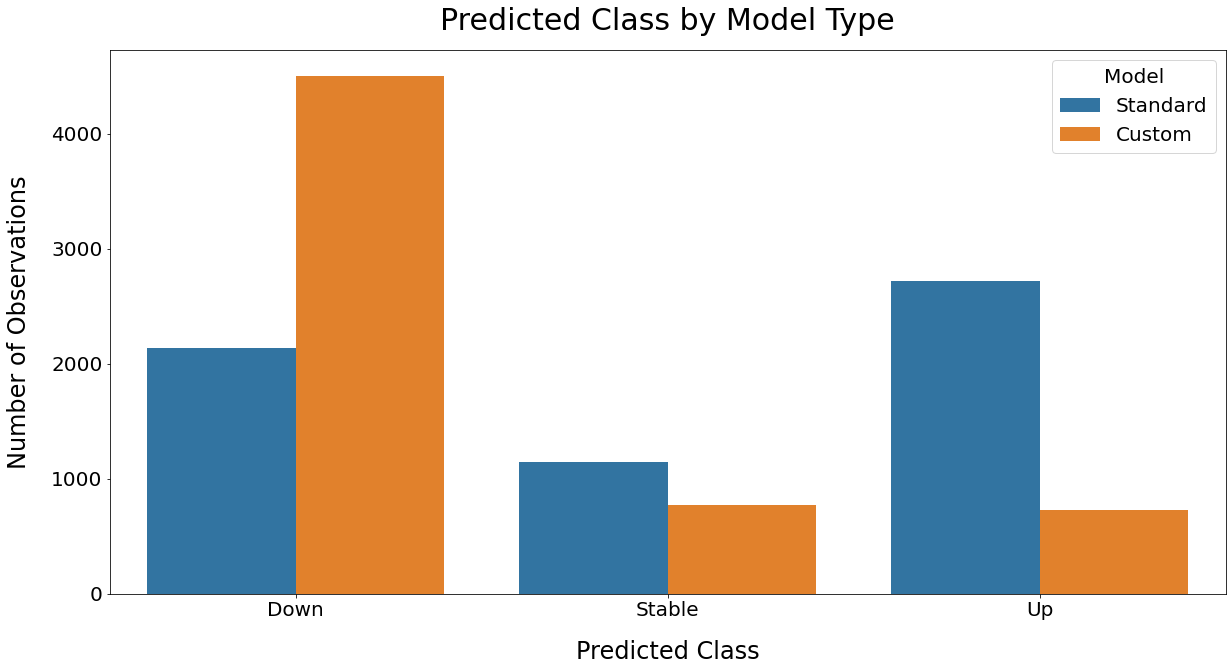

In [33]:
ax = sns.barplot(
    x='Class',
    y='Count',
    hue='Model',
    data=predicted_class_count
)

ax.set_title(label='Predicted Class by Model Type', pad=20, fontsize=30)
ax.set_xlabel(xlabel='Predicted Class', labelpad=20, fontsize=24)
ax.set_ylabel(ylabel='Number of Observations', labelpad=20, fontsize=24);